In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys, os
import h5py
sys.path.append('../')
import analysis_utils as utils

from matplotlib.ticker import LogLocator, NullFormatter, MultipleLocator
yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

from scipy.signal import savgol_filter, medfilt
from scipy.optimize import minimize

import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/vast/palmer/home.grace/yt388/microspheres/dm_nanospheres/analysis_notebooks/../analysis_utils.py'>

In [ ]:
data_dir = '/home/yt388/microspheres/dm_nanospheres/data_processed'
# data_dir = '/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed'

file = f'{data_dir}/sphere_data/sphere_20250103_recon_all.h5py'
with h5py.File(file, 'r') as fout:
    g = fout['recon_data_all']
    hist = g['hist'][:]
    n_window = g['hist'].attrs['n_windows']
    scaling = g['hist'].attrs['scaling']

    rate_all = g['rate_hist'][:]
    rate_all_err = g['rate_hist_err'][:]
    bc = g['bc'][:]

    time_all = g.attrs['time_hours']

    fout.close()

file = f'{data_dir}/sphere_data/sphere_20250103_calibration_all.h5py'
with h5py.File(file, 'r') as fout:
    g = fout['calibration_data_processed']
    eff_coefs = g['sig_efficiency_fit_params'][:]
    fout.close()

: 

In [4]:
from scipy.special import erf, zeta

def func2(x, z, f):
    return 0.5 * erf((x - z) * f) + 0.5

def power_law_corrected(x, xmin, a, eff_coefs=None):
    xx = np.linspace(0, 50000, 50000)

    if eff_coefs is not None:
        eff_xx = func2(xx, *eff_coefs)
        power_law_eff = eff_xx * np.power(xx, -1 * a) / zeta(a, xmin)
        power_law_eff[xx < xmin] = 0
        power_law_corrected_norm = np.trapz(power_law_eff, xx)
    else:
        power_law_corrected_norm = 1

    x = np.asarray(x)
    if eff_coefs is not None:
        eff_x = func2(x, *eff_coefs)
        ret = eff_x * np.power(x, -1 * a) / zeta(a, xmin)
    else:
        ret = np.power(x, -1 * a) / zeta(a, xmin)
    ret[x < xmin] = 0

    if ret.size == 1:
        return ret[0] / power_law_corrected_norm
    else:
        return ret / power_law_corrected_norm

# def half_gaus_mod(x, mu, m, n):
#     xx = np.linspace(0, 50000, 50000)
#     sigma = m * xx + n
#     _norm = np.trapz((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (xx - mu)**2 / (2 * sigma**2)), xx)

#     sigma_x = m * x + n
#     return (1 / (np.sqrt(2 * np.pi) * sigma_x)) * np.exp(-1 * (x - mu)**2 / (2 * sigma_x**2)) / _norm

def half_gaus_mod(x, mu, m, n, xmin):
    xx = np.linspace(0, 50000, 50000)

    sigma = np.empty_like(xx)
    sigma[xx < xmin] = n
    sigma[xx >= xmin] = m * (xx[xx >= xmin] - xmin) + n
    _norm = np.trapz((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (xx - mu)**2 / (2 * sigma**2)), xx)

    x = np.asarray(x)
    sigma_x = np.empty_like(x)
    sigma_x[x < xmin] = n
    sigma_x[x >= xmin] = m * (x[x >= xmin] - xmin) + n
    return (1 / (np.sqrt(2 * np.pi) * sigma_x)) * np.exp(-1 * (x - mu)**2 / (2 * sigma_x**2)) / _norm

def half_gaus_mod_fixed(x, mu, sigma):
    xx = np.linspace(0, 50000, 50000)
    _norm = np.trapz((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (xx - mu)**2 / (2 * sigma**2)), xx)

    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (x - mu)**2 / (2 * sigma**2)) / _norm

from scipy.special import gamma

def half_generalized_normal(x, mu, alpha, beta):
    return 2 * (beta / (2 * alpha * gamma(1 / beta)) ) * np.exp(-1 * (np.abs(x - mu) / alpha)**beta)

def half_gaus(x, sigma):
    return 2 * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-1 * (x)**2 / (2 * sigma**2))

def gaus(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-1 * (x - mu)**2 / (2 * sigma**2))

def crystal_ball_rev(x, alpha, n, mu, sigma):
    # Modified from https://arxiv.org/pdf/1603.08591
    # and https://en.wikipedia.org/wiki/Crystal_Ball_function

    x = np.asarray(x)
    ret = np.empty_like(x)

    A = np.power(n / np.abs(alpha), n) * np.exp(-1 * alpha**2 / 2)
    B = n / np.abs(alpha) - np.abs(alpha)

    # Flip the direction to get the tail on the positive side
    idx_gaus = ((x - mu) / sigma) < alpha
    idx_other = ((x - mu) / sigma) > alpha

    # Flip `B - ...` to `B + ...` to reverse the power law tail 
    ret[idx_gaus] = np.exp(-1 * (x[idx_gaus] - mu)**2 / (2 * sigma**2))
    ret[idx_other] = A * np.power((B + (x[idx_other] - mu) / sigma), (-1 * n))

    return ret

def crystal_ball_rev_normalized(x, alpha, n, mu, sigma):
    xx = np.linspace(0, 50000, 5000)
    func_val = crystal_ball_rev(xx, alpha, n, mu, sigma)
    norm = np.trapz(func_val, xx)

    x = np.asarray(x)
    if x.size == 1:
        return crystal_ball_rev(x, alpha, n, mu, sigma)[0] / norm
    else:
        return crystal_ball_rev(x, alpha, n, mu, sigma) / norm

def expo_corrected(x, cutoff, xi):
    # Re-normalize exponential after applying efficiency correction 
    # and truncate from below
    xx = np.linspace(0, 50000, 5000)

    expo_eff_truncated = np.exp(-1 * (xx) / xi) / xi
    expo_eff_truncated[xx < cutoff] = 0

    expo_corrected_norm = np.trapz(expo_eff_truncated, xx)

    x = np.asarray(x)
    ret = np.exp(-1 * (x) / xi) / xi
    ret[x < cutoff] = 0

    if ret.size == 1:
        return ret[0] / expo_corrected_norm
    else:
        return ret / expo_corrected_norm
    
def gaus_exp(x, k, mu, sigma):
    x = np.asarray(x)
    ret = np.empty_like(x)

    idx_gaus = ((x - mu) / sigma) >= (-1 * k)
    idx_other = ((x - mu) / sigma) < (-1 * k)

    ret[idx_gaus] = np.exp(-1 * (x[idx_gaus] - mu)**2 / (2 * sigma**2))
    ret[idx_other] = np.exp(k**2 / 2 + k * ((x[idx_other] - mu)/sigma))

    return ret

def expo(x, xi):
    x = np.asarray(x)
    ret = np.exp(-1 * (x) / xi) / xi

    if ret.size == 1:
        return ret[0]
    else:
        return ret

In [5]:
def get_mui(a, alpha, n, mu, sigma, cutoff, xi, bi, ntot):
    # Use only the central value of pdf
    # faster and avoid numerical issues from integration
    joint_pdf = a * crystal_ball_rev_normalized(bi, alpha, n, mu, sigma) + (1 - a) * expo_corrected(bi, cutoff, xi)
    mui = ntot * joint_pdf * 50

    return mui

def nll(a, alpha, n, mu, sigma, cutoff, xi, bc, hist):
    idx = bc > 1000
    bi = bc[idx]
    ni = hist[idx]

    # Total number of count in the entire range
    ntot = np.sum(hist)

    mui = get_mui(a, alpha, n, mu, sigma, cutoff, xi, bi, ntot)
    return np.sum(np.nan_to_num(mui - ni * np.log(mui)))


In [6]:
def plot_likelihood_fit(bc, hist, res_x):
    fig, axes = plt.subplots(2, 1, figsize=(7, 8), height_ratios=[4, 1])
    ana_threshold = 1000

    idx = bc > ana_threshold
    bi = bc[idx]
    ntot = np.sum(hist)

    hist_norm = n_window * scaling

    hist_fit_ml = get_mui(*res_x, bi, ntot)
    a, alpha, n, mu, sigma, cutoff, xi = res_x

    ax = axes[0]
    ax.fill_betweenx(np.logspace(-1, 9, 100), 0, ana_threshold, color='#B0C4DE', alpha=0.5)

    ax.errorbar(bi, hist[idx], yerr=np.sqrt(hist[idx]), fmt='.', color='#005AB5', alpha=1)
    ax.plot(bi, hist_fit_ml, '--', color='#DC143C', label='Reversed Crystal Ball + exponential (ML)')

    xx2 = np.linspace(1020, 10000, 500)
    crystal_ball_hist = ntot * 50 * a * crystal_ball_rev_normalized(xx2, alpha, n, mu, sigma)
    ax.fill_between(xx2, 0, crystal_ball_hist, color='#E1BE6A', alpha=0.25)

    xx1 = np.linspace(cutoff, 10000, 500)
    expo_hist = ntot * 50 * (1 - a) * expo_corrected(xx1, cutoff, xi)
    ax.fill_between(xx1, 0, expo_hist, color='#2E8B57', alpha=0.2)

    ax.set_yscale('log')
    ax.set_xlim(0, 8000)
    ax.set_ylim(1e-1, 1e9)

    ax.set_yticks(np.logspace(-1, 9, 11))
    locmin = LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=15)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.legend(frameon=False)
    ax.set_xticklabels([''])
    ax.set_ylabel('Counts / (50 keV/c)')

    ax = axes[1]
    ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')
    ax.fill_betweenx(np.linspace(-1000, 1000, 100), 0, ana_threshold, color='#B0C4DE', alpha=0.5)

    ax.set_xlim(0, 8000)
    ax.set_ylim(-150, 150)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.set_xlabel('Reconstructed amplitude (keV/c)')
    ax.set_ylabel('Residual ($\sigma_{\mathrm{stat}}$)')

    fig.suptitle('Sphere 20250103')
    fig.tight_layout()

    return fig, axes

Optimization terminated successfully.
         Current function value: -325398931.400860
         Iterations: 456
         Function evaluations: 960
[9.99999963e-01 3.88844938e+00 1.88930977e+01 1.64962666e+02
 2.55454974e+02 1.70317112e+03 3.73851449e+02]


/tmp/tmp.QiM92FqWUV/ipykernel_1378461/974970523.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])
/tmp/tmp.QiM92FqWUV/ipykernel_1378461/974970523.py:43: RuntimeWarning: divide by zero encountered in divide
  ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')


(<Figure size 700x800 with 2 Axes>,
 array([<Axes: ylabel='Counts / (50 keV/c)'>,
        <Axes: xlabel='Reconstructed amplitude (keV/c)', ylabel='Residual ($\\sigma_{\\mathrm{stat}}$)'>],
       dtype=object))

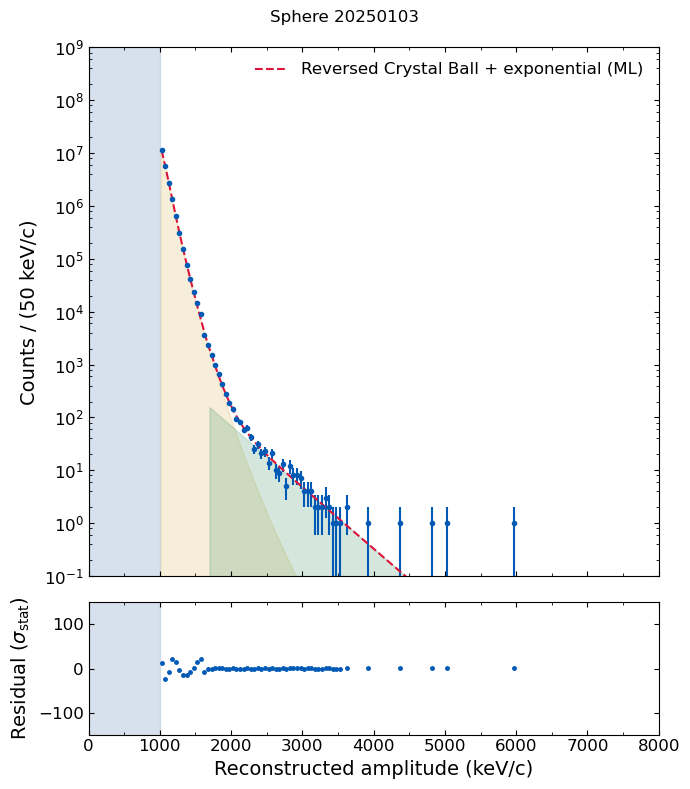

In [7]:
ntot = np.sum(hist)
args = (bc, hist)

res = minimize(fun=lambda x: nll(*x, *args), 
               method='Nelder-Mead',
               x0 = [0.999999963, 3.88913877, 18.8311789, 164.921104, 255.466148, 1700.34007, 388.650890],
               bounds = [(0.9999, 1), (3, 4), (10, 30), (100, 200), (200, 300), (1400, 2000), (300, 500)],

               options={'disp' : True,
                        'maxiter': 10000,
                        'maxfev': 10000,
                        'adaptive': True,
                        'fatol': 0.0001,
                        }
               )

param_nodm = res.x
nll_nodm   = res.fun

print(res.x)

plot_likelihood_fit(bc, hist, res.x)

In [99]:
data_dir = '/home/yt388/microspheres/dm_nanospheres/data_processed'

def smooth_nlls(alpha_list, nlls):
    for i, nll in enumerate(nlls):
        if i == 0 or i > (nlls.size - 2):
            continue

        if np.abs(nll - nlls[i-1]) > 5 :
            nlls[i] = np.interp(alpha_list[i], [alpha_list[i-1], alpha_list[i+1]], [nlls[i-1], nlls[i+1]])

    return nlls

def get_upper_alpha(alpha_list, nlls):
    # Remove nan from the nlls
    _nlls = nlls[~np.isnan(nlls)]
    _alpha = alpha_list[~np.isnan(nlls)]
    if _nlls.size == 0:
        return np.nan
    
    _nlls = smooth_nlls(_alpha, _nlls)
    idx_ml = np.argmin(_nlls)

    # Remove spikes in the nlls using a median filter
    # _nlls = medfilt(_nlls, 3)
    
    # Make sure minimum point is not a spike
    # if idx_ml != 0 and idx_ml < _nlls.size-1:
    #     if np.abs(_nlls[idx_ml - 1] - _nlls[idx_ml]) > 5 and np.abs(_nlls[idx_ml+1] - _nlls[idx_ml]) > 5:
    #         _nll[idx_ml] = np.interp(_alpha[i], [_alpha[i-1], _alpha[i+1]], [_nll[i-1], _nll[i+1]])
    #         idx_ml = np.argmin(_nlls)


    if np.max(_nlls - _nlls[idx_ml]) < 5:
        return np.nan

    # Make sure NLLs are strictly increasing above the
    # maximum likelihood alpha
    idx_search = _alpha >= _alpha[idx_ml]
    if np.sum(idx_search) == 0:
        return np.nan

    delta_nlls = _nlls[idx_search] - _nlls[idx_ml]

    return np.interp(3.841, 2*delta_nlls, _alpha[idx_search], left=np.nan, right=np.nan)

def get_alpha_limits(mphi, dataset='coarse'):
    nlls_file = np.load(fr'{data_dir}/profile_nlls/profile_nlls_{mphi:.0e}_{dataset}.npz')

    nlls = nlls_file['nll']
    mx_list, alpha_list = nlls_file['mx'], nlls_file['alpha']

    alpha_upper = np.empty(mx_list.size)
    for i in range(mx_list.size):
        alpha_upper[i] = get_upper_alpha(alpha_list, nlls[i])

    return mx_list, alpha_upper, alpha_list, nlls


In [80]:
lim_10ev_coarse = get_alpha_limits(10, 'coarse')
lim_1ev_coarse = get_alpha_limits(1, True)
lim_0_1ev_coarse = get_alpha_limits(0.1, True)
lim_0_01ev_coarse = get_alpha_limits(0.01, True)

Text(0, 0.5, '95% CL Upper limit on $\\alpha_n$')

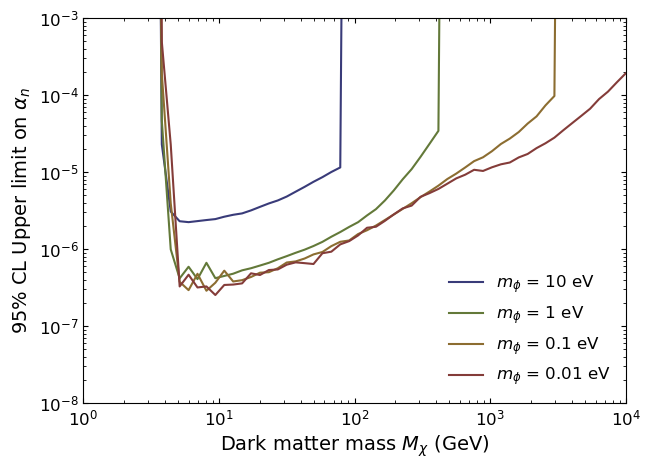

In [100]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(lim_10ev_coarse[0], np.nan_to_num(lim_10ev_coarse[1], nan=1e10),     '-', label='$m_\phi$ = 10 eV')
ax.plot(lim_1ev_coarse[0], np.nan_to_num(lim_1ev_coarse[1], nan=1e10),       '-', label='$m_\phi$ = 1 eV')
ax.plot(lim_0_1ev_coarse[0], np.nan_to_num(lim_0_1ev_coarse[1], nan=1e10),   '-', label='$m_\phi$ = 0.1 eV')
ax.plot(lim_0_01ev_coarse[0], np.nan_to_num(lim_0_01ev_coarse[1], nan=1e10), '-', label='$m_\phi$ = 0.01 eV')

plt.xlim(1e0, 1e4)
plt.ylim(1e-8, 1e-3)

plt.yscale('log')
plt.xscale('log')

plt.legend(frameon=False)
plt.xlabel(r'Dark matter mass $M_\chi$ (GeV)')
plt.ylabel(r'95% CL Upper limit on $\alpha_n$')

In [101]:
idx = np.logical_and(lim_0_01ev_coarse[0] > 40, lim_0_01ev_coarse[0] < 100)

lim_0_01ev_coarse[1]

array([           nan,            nan, 9.15327606e-04,            nan,
                  nan,            nan,            nan,            nan,
       9.42352443e-04,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
       4.94274015e-04, 2.28811037e-05, 3.28172404e-07, 4.66082794e-07,
       3.18299449e-07, 3.28481228e-07, 2.54005931e-07, 3.42992274e-07,
       3.47224423e-07, 3.59660120e-07, 4.86063538e-07, 4.61864425e-07,
       5.36226998e-07, 5.45429162e-07, 6.29092498e-07, 6.74332196e-07,
       6.58569220e-07, 6.41917807e-07, 8.85976248e-07, 9.28086776e-07,
       1.15444572e-06, 1.27321737e-06, 1.50914708e-06, 1.89775423e-06,
       1.95576192e-06, 2.33103821e-06, 2.82950815e-06, 3.38609020e-06,
       3.68066323e-06, 4.78860747e-06, 5.34674433e-06, 6.05710501e-06,
      

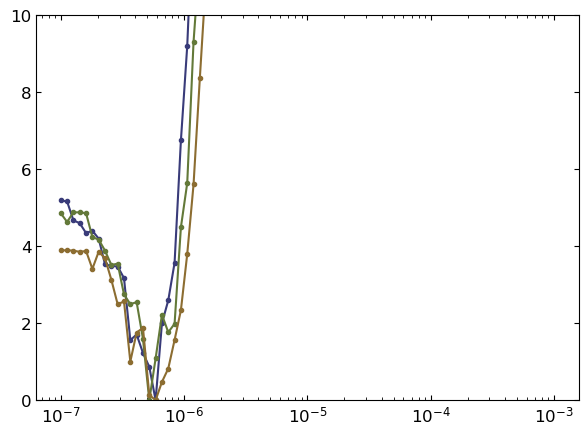

In [95]:
from scipy.signal import find_peaks, medfilt

mx_list, alpha_upper, alpha_list, nlls = lim_0_01ev_coarse

for i in range(40, 43):
    _nll = nlls[i][~np.isnan(nlls[i])]
    _alpha = alpha_list[~np.isnan(nlls[i])]

    # _nll = medfilt(_nll, 3)
    delta_nll = _nll - np.min(_nll)
    plt.plot(_alpha, delta_nll, '.-')

plt.ylim(0, 10)
plt.xscale('log')

In [18]:
nlls_file = np.load(r'/home/yt388/microspheres/dm_nanospheres/data_processed/profile_nlls/profile_nlls_1e+01_coarse.npz')
nlls = nlls_file['nll']
mx_list, alpha_list = nlls_file['mx'], nlls_file['alpha']

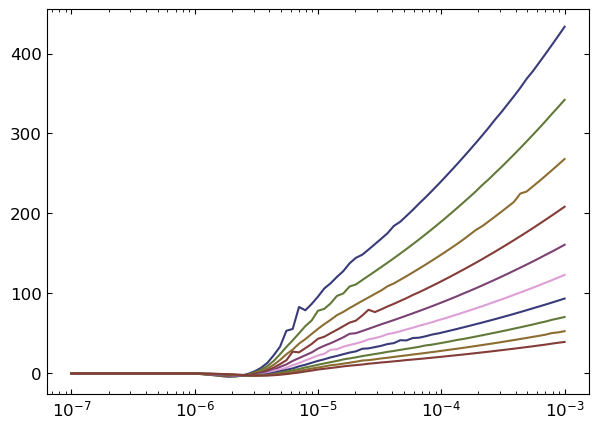

In [26]:
for i in range(30, 40):
    plt.plot(alpha_list, nlls[i], '-')
plt.xscale('log')


In [6]:
lim_0_01ev_2 = get_alpha_limits(0.01, 2)
lim_0_1ev_2 = get_alpha_limits(0.1, 2)
lim_1ev_2 = get_alpha_limits(1, 2)
lim_10ev_2 = get_alpha_limits(10, 2)
lim_10ev_3 = get_alpha_limits(10, 3)

In [7]:
outfile_name = 'alpha_limits_all.h5py'
with h5py.File(os.path.join(data_dir, outfile_name), 'w') as fout:
    print(f'Writing file {os.path.join(data_dir, outfile_name)}')

    g = fout.create_group('alpha_lim_95cl')

    g0 = g.create_dataset('mx_gev', data=lim_0_01ev_2[0], dtype=np.float64)

    g1 = g.create_dataset('alpha_lim_0_01ev', data=lim_0_01ev_2[1], dtype=np.float64)
    g2 = g.create_dataset('alpha_lim_0_1ev', data=lim_0_1ev_2[1], dtype=np.float64)
    g3 = g.create_dataset('alpha_lim_1ev', data=lim_1ev_2[1], dtype=np.float64)
    g3 = g.create_dataset('alpha_lim_10ev', data=lim_10ev_2[1], dtype=np.float64)

    fout.close()

Writing file /home/yt388/microspheres/impulse_analysis/data_processed/alpha_limits_all.h5py


In [7]:
mx_list_2 = lim_10ev_2[0]
idx_plot = np.logical_and(mx_list_2 > 1, mx_list_2 < 1e4)

mx_interp = mx_list_2[idx_plot]
mx_plot = np.logspace(-1, 4, 200)

In [2]:
mx_list_fine = np.logspace(-1, 4, 153)

In [5]:
mx_list_fine[np.logical_and(mx_list_fine > 4, mx_list_fine < 30)]

array([ 4.09111893,  4.41302962,  4.76026992,  5.13483291,  5.53886848,
        5.97469568,  6.44481605,  6.95192796,  7.49894209,  8.08899816,
        8.72548294,  9.41204967, 10.15263908, 10.95150193, 11.81322351,
       12.74274986, 13.74541621, 14.8269776 , 15.99364192, 17.2521055 ,
       18.60959159, 20.0738918 , 21.65341083, 23.35721469, 25.19508277,
       27.17756395, 29.31603714])